In [ ]:
#  Perform seasonal differencing for first-order differenced dataset.
seasonal_diff = airpass_diff1.diff(12)
seasonal_diff.head(20)

,#Passengers
Month,
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN
1949-10-01,NaN


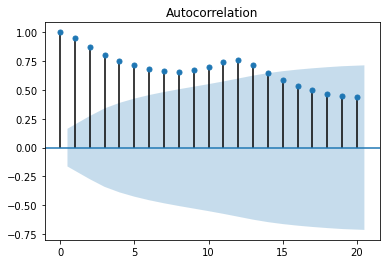

In [ ]:
# Plot ACF for indexed DataFrame for identifying m
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(airpass_in_df, lags = 20)
plt.show()

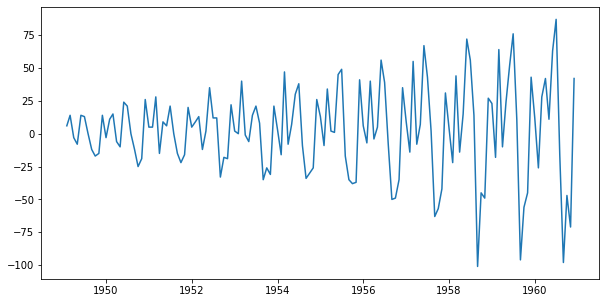

In [ ]:
#  Plot first-order differenced data and identify order 'D'
plt.figure(figsize = (10, 5))
plt.plot(airpass_diff1['#Passengers'])
plt.show()

In [ ]:
#  Remove NaN values and check stationarity of seasonal differenced data.
seasonal_diff.dropna(inplace = True)
adf_df3 = adfuller(seasonal_diff['#Passengers'])
print('ADF Statistic:', adf_df3[0])
print('p-value: ', adf_df3[1])

ADF Statistic: -15.595618083746338
p-value:  1.856511600123444e-28


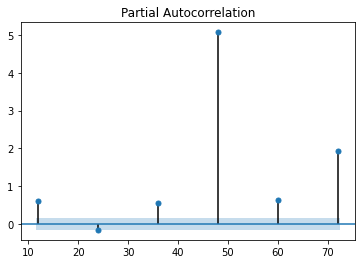

In [ ]:
#  Plot PACF for first-order differenced data at lags 12, 24, 36, 48, 60, 72
plot_pacf(airpass_diff1, lags = [12, 24, 36, 48, 60, 72])
plt.show()

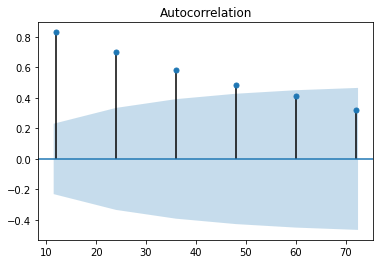

In [ ]:
#  Plot ACF for first-order differenced data at lags 12, 24, 36, 48, 60, 72
plot_acf(airpass_diff1, lags = [12, 24, 36, 48, 60, 72])
plt.show()

In [ ]:
#  Deploy SARIMA model.
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(airpass_in_df, order = (4, 1, 4), seasonal_order = (1, 1, 0, 12)).fit()
print(sarima_model.aic)

1018.2995723514282


MAE: 8.85391485295005
RMSE: 11.945696621987313
MAPE: 3.7314732020891044


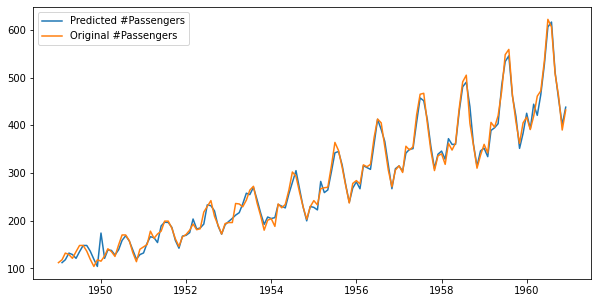

In [ ]:
# Perform prediction using 'predict()' function for original dataset.

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict using `predict()` function with start = 1 and end = (total observations - 1)
pred = sarima_model.predict(1, len(airpass_in_df) - 1)

# Print MAE, RMSE, MAPE values
print("MAE:", mean_absolute_error(airpass_in_df[1:], pred))
print("RMSE:", np.sqrt(mean_squared_error(airpass_in_df[1:], pred)))

print("MAPE:", calculate_mape(airpass_in_df['#Passengers'].iloc[1:], pred))

# Plot predictions and actual values
plt.figure(figsize=(10, 5))
plt.plot(pred, label = 'Predicted #Passengers')
plt.plot(airpass_in_df['#Passengers'], label = 'Original #Passengers')
plt.legend()
plt.show()

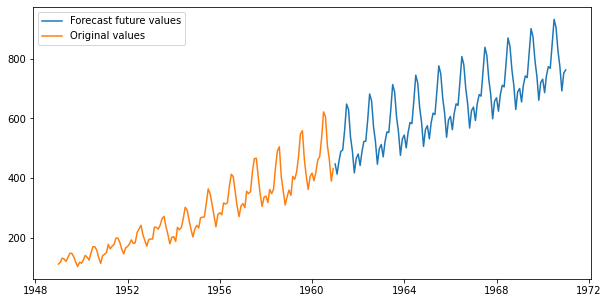

In [ ]:
#  Perform prediction for new values. Plot the forecast values
sarima_forecast = sarima_model.predict(start = 144, end = 264, typ = 'levels')
plt.figure(figsize=(10, 5))
plt.plot(sarima_forecast, label = 'Forecast future values')
plt.plot(airpass_in_df['#Passengers'], label = 'Original values')
plt.legend()
plt.show()

In [ ]:
#  Generate all different combinations of p, q and q triplets
import itertools
p = d = q = range(0, 2)

pdq_combination = list(itertools.product(p, d, q))
pdq_combination

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [ ]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdqm = [(x[0], x[1], x[2], 12) for x in pdq_combination]
seasonal_pdqm

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [ ]:
#  Perform Grid Search Hyperparameter tuning for SARIMAX
# Import 'statsmodels.api' library
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Create 3 variables to store lowest AIC score, best non-seasonal order and best seasonal order
# Set lowest AIC Score to "inf", non-seasonal and seasonal order to 'None'
lowest_aic, best_order, best_s_order = float("inf"), None, None

# Create a for loop for non-seasonal order
for pdq in pdq_combination:
  # Create a for loop for seasonal order
  for PDQM in seasonal_pdqm:
    # Add a try block to fit and get the AIC Score
    try:
      # Perform SARIMA operation using SARIMAX() function
      model = sm.tsa.statespace.SARIMAX(airpass_in_df, order = pdq, seasonal_order= PDQM).fit()

      # Get the AIC score and print the result
      aic_m = model.aic
      print(f'SARIMAX{pdq}{PDQM} AIC={aic_m:.3f}')

      # Put a condition to get the lowest AIC Score and change the orders
      if aic_m < lowest_aic:
        lowest_aic, best_order, best_s_order = aic_m, pdq, PDQM

    # Put an except block inside that continue condition
    except:
      continue

# Print the best SARIMA order for both seasonal and non-seasonal
print(f'Best SARIMAX {best_order}{best_s_order} AIC={lowest_aic:.3f}')

SARIMAX(0, 0, 0)(0, 0, 0, 12) AIC=2057.847
SARIMAX(0, 0, 0)(0, 0, 1, 12) AIC=1906.618
SARIMAX(0, 0, 0)(0, 1, 0, 12) AIC=1324.954
SARIMAX(0, 0, 0)(0, 1, 1, 12) AIC=1274.613
SARIMAX(0, 0, 0)(1, 0, 0, 12) AIC=1501.320
SARIMAX(0, 0, 0)(1, 0, 1, 12) AIC=1451.300
SARIMAX(0, 0, 0)(1, 1, 0, 12) AIC=1221.243
SARIMAX(0, 0, 0)(1, 1, 1, 12) AIC=1176.982
SARIMAX(0, 0, 1)(0, 0, 0, 12) AIC=1870.304
SARIMAX(0, 0, 1)(0, 0, 1, 12) AIC=1723.646
SARIMAX(0, 0, 1)(0, 1, 0, 12) AIC=1214.066
SARIMAX(0, 0, 1)(0, 1, 1, 12) AIC=1189.827
SARIMAX(0, 0, 1)(1, 0, 0, 12) AIC=1393.455
SARIMAX(0, 0, 1)(1, 0, 1, 12) AIC=1387.805
SARIMAX(0, 0, 1)(1, 1, 0, 12) AIC=1161.840
SARIMAX(0, 0, 1)(1, 1, 1, 12) AIC=1120.201
SARIMAX(0, 1, 0)(0, 0, 0, 12) AIC=1413.909
SARIMAX(0, 1, 0)(0, 0, 1, 12) AIC=1302.690
SARIMAX(0, 1, 0)(0, 1, 0, 12) AIC=1031.508
SARIMAX(0, 1, 0)(0, 1, 1, 12) AIC=1030.752
SARIMAX(0, 1, 0)(1, 0, 0, 12) AIC=1150.761
SARIMAX(0, 1, 0)(1, 0, 1, 12) AIC=1150.883
SARIMAX(0, 1, 0)(1, 1, 0, 12) AIC=1030.408
SARIMAX(0, 